In [2]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors
import wgan
sys.path.append('../mnist_cnn')
import mnistCnn
#import shap
#import google.protobuf
#import h5py
#from lime import lime_image
from skimage.color import gray2rgb

In [23]:
#google.protobuf.__version__
#h5py.__version__

'3.1.0'

In [3]:
# load gan
gan = wgan.WGan()
genPath = "./wGan_1000_epochs/wgan_generator.h5"
discPath = "./wGan_1000_epochs/wgan_discriminator.h5"
invPath = "./wGan_1000_epochs/wgan_inverter.h5"
gan.load_gan(genPath, discPath, invPath)

In [4]:
# load cnn
cnn = mnistCnn.MnistCnn()
cnn.loadWeights('../mnist_cnn/largerCnn30Epochs')

In [5]:
# load mnist dataset
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255

In [26]:
#background = test_data[np.random.choice(test_data.shape[0], 100, replace=False)]
#shap_explainer = shap.DeepExplainer(cnn.model, background)
#lime_explainer = lime_image.LimeImageExplainer()

In [63]:
"""test_img = np.expand_dims(test_data[0], 0)
y = y_test[0]
z = gan.inverter(test_img)
delta_z = np.random.randn(5000, z.shape[1]) #5000 128dim vectors
d = np.random.rand(5000) * (10) #5000 values in (0, 10] random uniformly distr
norm_p = np.linalg.norm(delta_z, ord = 2, axis = 1) #norm of each 128dim vec (5000 vectors)
d_norm = np.divide(d, norm_p).reshape(-1, 1) # values
delta_z = np.multiply(delta_z, d_norm)
z_tilde = z+delta_z
x_tilde = gan.generator(z_tilde)
y_tilde = cnn.model(x_tilde)
y_tilde = np.argmax(y_tilde, axis = 1)
indices_adv = np.where(y_tilde != y)[0]
idx = indices_adv[np.argmin(d[indices_adv])]
print(y_tilde[idx])"""

2


In [6]:
# hybrid shrinking search algorithm to generate adversaries
# https://github.com/zhengliz/natural-adversary/blob/master/image/search.py
# "Generating Natural Adversarial Examples"
def recursive_search(gen, inv, cnn, x, y, y_t = None, z = None, n_samples = 5000, step = 0.01, l = 0., h = 10., stop = 5, p = 2, verbose = False):
    x_adv, y_adv, z_adv, d_adv = None, None, None, None
    # recursion
    counter = 1
    if(z is None):
        z = inv(x)
    while(True):
        delta_z = np.random.randn(n_samples, z.shape[1]) #n_samples latent space elements
        d = np.random.rand(n_samples) * (h - l) + l
        norm_p = np.linalg.norm(delta_z, ord = p, axis = 1)
        d_norm = np.divide(d, norm_p).reshape(-1, 1)
        delta_z = np.multiply(delta_z, d_norm)
        z_tilde = z + delta_z    # z tilde
        x_tilde = gen(z_tilde)   # x tilde
        y_tilde = cnn(x_tilde)   # y tilde
        y_tilde = np.argmax(y_tilde, axis = 1) # need the class, not confidence vector
        # n_samples y_tilde values generated, get the first fitting:
        if(y_t is None):
            indices_adv = np.where(y_tilde != y)[0]
        else:
            indices_adv = np.where(y_tilde == y_t)[0]
        if len(indices_adv) == 0:       # no candidate generated
            if h - l < step:
                break
            else:
                l = l + (h - l) * 0.5
                counter = 1
        else:                           # certain candidates generated
            idx_adv = indices_adv[np.argmin(d[indices_adv])]
            if y_t is None:
                assert (y_tilde[idx_adv] != y)
            else:
                assert (y_tilde[idx_adv] == y_t)
            if d_adv is None or d[idx_adv] < d_adv:
                x_adv = x_tilde[idx_adv]
                y_adv = y_tilde[idx_adv]
                z_adv = z_tilde[idx_adv]
                d_adv = d[idx_adv]
                l, h = d_adv * 0.5, d_adv
                counter = 1
            else:
                h = l + (h - l) * 0.5
                counter += 1
            if counter > stop or h - l < step:
                break
    # iteration
    if(d_adv is not None):
        h = d_adv
    l = max(0., h - step)
    counter = 1
    while(counter <= stop and h > 1e-4):
        delta_z = np.random.randn(n_samples, z.shape[1])
        d = np.random.rand(n_samples) * (h - l) + l
        norm_p = np.linalg.norm(delta_z, ord = p, axis = 1)
        d_norm = np.divide(d, norm_p).reshape(-1, 1)
        delta_z = np.multiply(delta_z, d_norm)
        z_tilde = z + delta_z
        x_tilde = gen(z_tilde)
        y_tilde = cnn(x_tilde)
        y_tilde = np.argmax(y_tilde, axis = 1)
        if y_t is None:
            indices_adv = np.where(y_tilde != y)[0]
        else:
            indices_adv = np.where(y_tilde == y_t)[0]
        if len(indices_adv) == 0:
            counter += 1
        else:
            idx_adv = indices_adv[np.argmin(d[indices_adv])]
            if y_t is None:
                assert (y_tilde[idx_adv] != y)
            else:
                assert (y_tilde[idx_adv] == y_t)
            if d_adv is None or d[idx_adv] < d_adv:
                x_adv = x_tilde[idx_adv]
                y_adv = y_tilde[idx_adv]
                z_adv = z_tilde[idx_adv]
                d_adv = d[idx_adv]
            h = l
            l = max(0., h - step)
            counter = 1
    # return
    adversary = {'x': x, 'y': y, 'z': z,
                 'x_adv': x_adv, 'y_adv': y_adv, 'z_adv': z_adv, 'd_adv': d_adv}
    return adversary

In [7]:
test_img = np.expand_dims(test_data[0], 0)
print(test_img.shape)
test_z = gan.inverter(test_img)
print(test_z.shape)
test_gen = gan.generator(test_z)
print(test_gen.shape)

(1, 28, 28, 1)
(1, 128)
(1, 28, 28, 1)


In [35]:
"""fig, ax = plt.subplots(10,3, figsize = (10,30))
for i in range(10):
    ax[i,0].matshow(np.random.rand(28,28))
    ax[i,0].set_title('0')
    ax[i,0].axis('off')
    ax[i,1].matshow(np.random.rand(28,28))
    ax[i,1].set_title('1')
    ax[i,1].axis('off')
    ax[i,2].matshow(np.random.rand(28,28))
    ax[i,2].axis('off')
    #ax[i,1].set_title('1')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4, left = 0.1)
plt.show"""

"fig, ax = plt.subplots(10,3, figsize = (10,30))\nfor i in range(10):\n    ax[i,0].matshow(np.random.rand(28,28))\n    ax[i,0].set_title('0')\n    ax[i,0].axis('off')\n    ax[i,1].matshow(np.random.rand(28,28))\n    ax[i,1].set_title('1')\n    ax[i,1].axis('off')\n    ax[i,2].matshow(np.random.rand(28,28))\n    ax[i,2].axis('off')\n    #ax[i,1].set_title('1')\nplt.subplots_adjust(wspace = 0.0, hspace = 0.4, left = 0.1)\nplt.show"

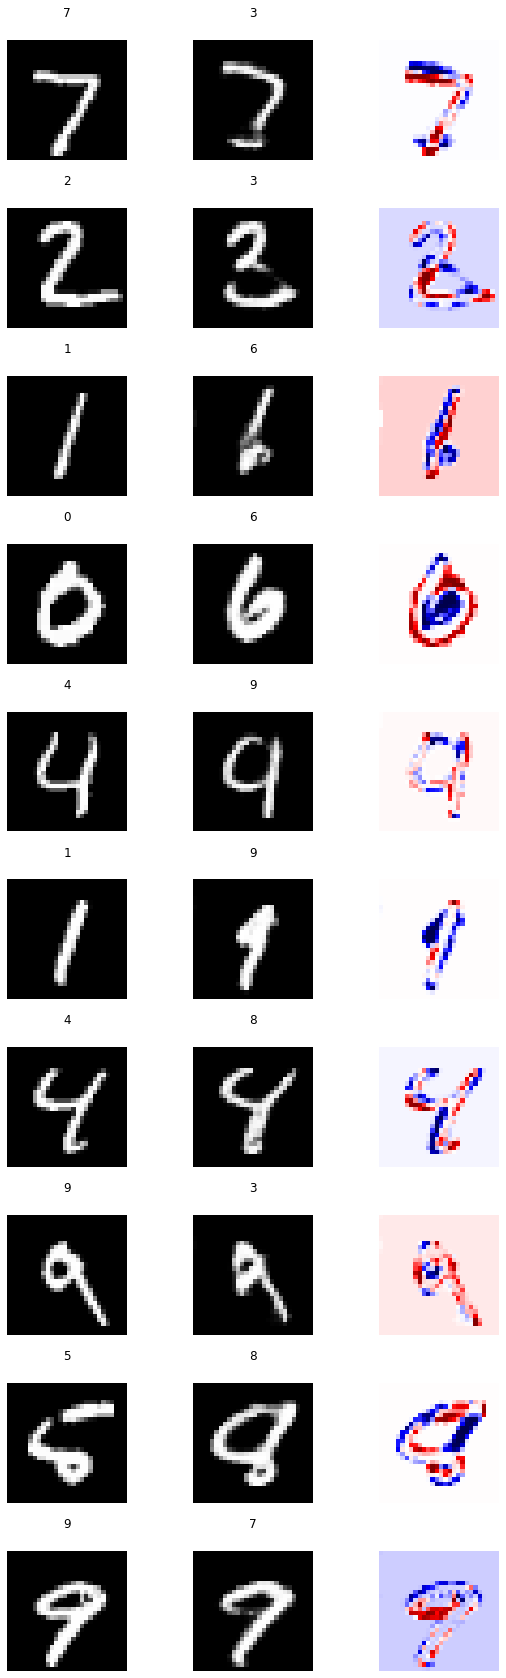

In [34]:
norm = colors.Normalize(vmin = 0, vmax = 1)
fig, ax = plt.subplots(10, 3, sharey = False, figsize=(10,30))
for i in range(10):
    img = test_data[i]
    label = y_test[i]
    adversary = recursive_search(gan.generator, gan.inverter, cnn.model, np.expand_dims(img, 0), label)
    x_adversary = adversary['x_adv']
    diff = img - x_adversary
    im0 = ax[i,0].matshow(img, cmap = 'gray', interpolation = 'none')
    im0.set_norm(norm)
    ax[i,0].set(title=str(label))
    ax[i,0].axis('off')
    im1 = ax[i,1].matshow(x_adversary, cmap = 'gray', interpolation = 'none')
    im1.set_norm(norm)
    ax[i,1].set(title=str(adversary['y_adv']))
    ax[i,1].axis('off')
    im2 = ax[i,2].matshow(diff, cmap = 'seismic', interpolation = 'none')
    #im2.set_norm(norm)
    ax[i,2].axis('off')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4)

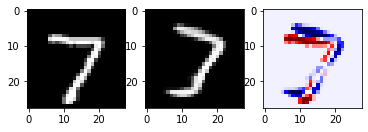

In [11]:
x_adversary = adversary['x_adv']
diff_img = test_data[0] - x_adversary
###(gen, inv, cnn, x, y, y_t = None, z = None, n_samples = 5000, step = 0.01, l = 0., h = 10., stop = 5, p = 2, verbose = False):
norm = colors.Normalize(vmin = 0, vmax = 1)
#norm2 = colors.Normalize(vmin = -1, vmax = 0)
fig, ax = plt.subplots(1,3)
im1 = ax[0].imshow(test_data[0], cmap = 'gray', interpolation = 'none')
im1.set_norm(norm)
im2 = ax[1].imshow(x_adversary, cmap = 'gray', interpolation = 'none')
im2.set_norm(norm)
im3 = ax[2].imshow(diff_img, cmap = 'seismic', interpolation = 'none')

In [12]:
print(adversary['y_adv'])

3


In [15]:
print(test_data[0].shape)

(28, 28, 1)


In [40]:
lime_test_img = gray2rgb(np.squeeze(test_data[0],-1))
#print(lime_test_img.shape)
#plt.imshow(lime_test_img, cmap = 'brg', interpolation = 'none')
lime_explanation = lime_explainer.explain_instance(lime_test_img, cnn.model, top_labels = 10, hide_color = 0, num_samples = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (10, 28, 28, 3)

In [35]:
shap_values = shap_explainer.shap_values(test_data)

StagingError: in user code:

    /opt/conda/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:252 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/backprop.py:1074 gradient  **
        flat_grad = imperative_grad.imperative_grad(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/registry.py:99 lookup
        raise LookupError(

    LookupError: gradient registry has no entry for: shap_FusedBatchNormV3
